In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def exponentialdecay_testing():
    #generation of data for testing
    x_axis = np.linspace(1, 51, 20)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)
    
    mod, params = fitlogic.make_decayexponential_model()
    print('Parameters of the model', mod.param_names, ' with the independet variable', mod.independent_vars)

    params['amplitude'].value = -100 + abs(np.random.normal(0,200))
    params['lifetime'].value = 1 + abs(np.random.normal(0,20))
    params['offset'].value = 1 + abs(np.random.normal(0, 200))
    print('\n',
          'amplitude', params['amplitude'].value, '\n',
          'lifetime', params['lifetime'].value, '\n',
          'offset', params['offset'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 10* np.random.normal(size=x_axis.shape))
    
    result = fitlogic.make_decayexponential_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponential)
    
    data = data_noisy
    offset = data[-max(1,int(len(x_axis)/10)):].mean()

    #substraction of offset
    if data[0]<data[-1]:
        data_level = offset - data
    else:
        data_level = data - offset
    for i in range(0, len(x_axis)):
        if data_level[i] <= data_level.std():
            break
    print(i)
    
    try:
        data_level_log = np.log(data_level[0:i])
        linear_result = fitlogic.make_linear_fit(
            axis=x_axis[0:i],
            data=data_level_log,
            estimator=fitlogic.estimate_linear)
        plt.plot(x_axis[0:i], data_level_log, 'ob')
        plt.plot(x_axis[0:i], linear_result.best_fit,'-r')
        plt.plot(x_axis[0:i], linear_result.init_fit,'-y')
        plt.show()
    except:
        plt.plot(x_axis, np.log(data_level), 'or')
        plt.show()
        print("linear fitting poorly conditioned")
        
    plt.plot(x_axis, data_noisy, 'ob')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g')
    print(result.fit_report())
    plt.plot(x_axis, result.init_fit, '-y', linewidth=2.0)
    plt.plot(x_axis, result.best_fit, '-r', linewidth=2.0)
    plt.show()


Parameters of the model ['amplitude', 'beta', 'lifetime', 'offset']  with the independet variable x

 amplitude 168.90884821148666 
 lifetime 15.819764351888473 
 offset 151.96023204571253
8
linear fitting poorly conditioned
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 20
    # variables        = 3
    chi-square         = 2439.854
    reduced chi-square = 143.521
[[Variables]]
    beta:        1 (fixed)
    amplitude:   165.054872 +/- 11.09073 (6.72%) (init= 163.4841)
    lifetime:    19.5988285 +/- 4.175482 (21.30%) (init= 21.17625)
    offset:      148.682452 +/- 12.04065 (8.10%) (init= 168.9946)
[[Correlations]] (unreported correlations are <  0.100)
    C(lifetime, offset)          = -0.926 
    C(amplitude, offset)         = -0.611 
    C(amplitude, lifetime)       =  0.353 



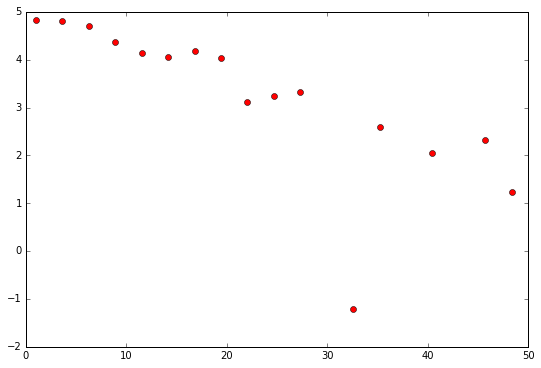

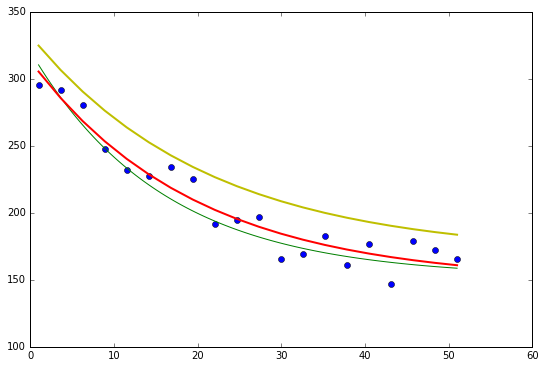

In [3]:
exponentialdecay_testing()

In [4]:
def bareexponentialdecay_testing():
    #generation of data for testing
    x_axis = np.linspace(1, 100, 70)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 200)

    mod, params = fitlogic.make_bareexponentialdecay_model()
    print('Parameters of the model', mod.param_names, ' with the independent variable', mod.independent_vars)

    params['lifetime'].value = 1 + abs(np.random.normal(0,25))
    print('\n''lifetime', params['lifetime'].value)

    data_noisy = abs(mod.eval(x=x_axis, params=params) + 0.125 * np.random.normal(size=x_axis.shape))

    nice_data = mod.eval(x=x_nice, params=params)

    offset = data_noisy.min()

    leveled_data = data_noisy - offset

    plt.figure()
    plt.plot(x_nice, nice_data, label='ref exp. decay data no offest')
    plt.plot(x_nice, nice_data + 1, label='ref exp. decay data +1 offset')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.,
               prop={'size':12}, title='ref nice data')
    plt.show()

    plt.figure()
    plt.plot(x_nice, np.log(nice_data), label='ref exp. decay data no offest, log')
    plt.plot(x_nice, np.log(nice_data+1), label='ref exp. decay data +1 offset, log')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.,
               prop={'size':12}, title='ref nice data, log')
    plt.show()


    data_log = np.log(leveled_data)

    linear_result = fitlogic.make_linear_fit(
        x_axis=x_axis,
        data=data_log,
        estimator=fitlogic.estimate_linear)
    
    plt.figure()
    plt.plot(x_axis, data_log, 'ob', label='logarithmic data')
    plt.plot(x_axis, linear_result.best_fit,'-r', label='best fit')
    plt.plot(x_axis, linear_result.init_fit,'-y', label='initial fit')
    plt.xlabel('Time x')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    result = fitlogic.make_decayexponential_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponential)
    
    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_noisy, 'ob',label='noisy data')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g', label='simulated data')
    plt.plot(x_axis, result.init_fit, '-y', linewidth=1.0, label='initial values')
    plt.plot(x_axis, result.best_fit, '-r', linewidth=1.0, label='best fit')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.xlabel('Time x')
    plt.ylabel('signal')
    plt.show()

Parameters of the model ['beta', 'lifetime']  with the independent variable x

lifetime 54.299827046046076
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 70
    # variables        = 3
    chi-square         = 1.053
    reduced chi-square = 0.016
[[Variables]]
    beta:        1 (fixed)
    amplitude:   0.99451034 +/- 0.097905 (9.84%) (init= 0.9315937)
    lifetime:    52.4803035 +/- 14.60693 (27.83%) (init= 61.01976)
    offset:      0.02007167 +/- 0.120154 (598.63%) (init= 0.2134887)
[[Correlations]] (unreported correlations are <  0.100)
    C(lifetime, offset)          = -0.965 
    C(amplitude, offset)         = -0.888 
    C(amplitude, lifetime)       =  0.765 



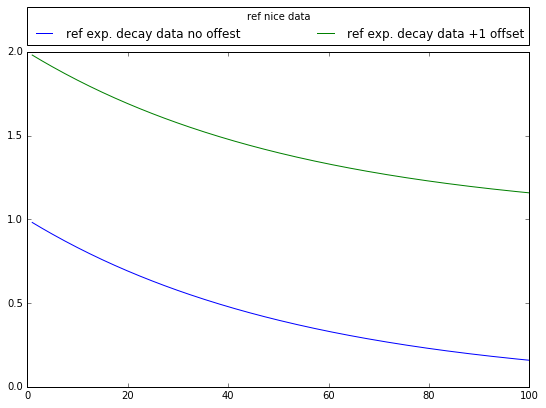

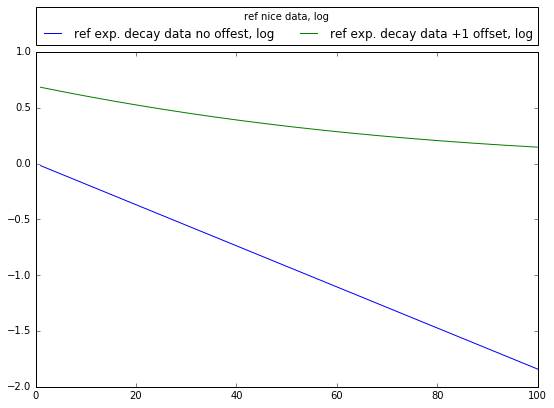

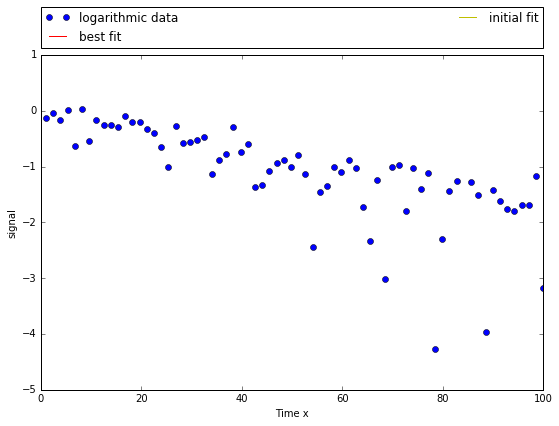

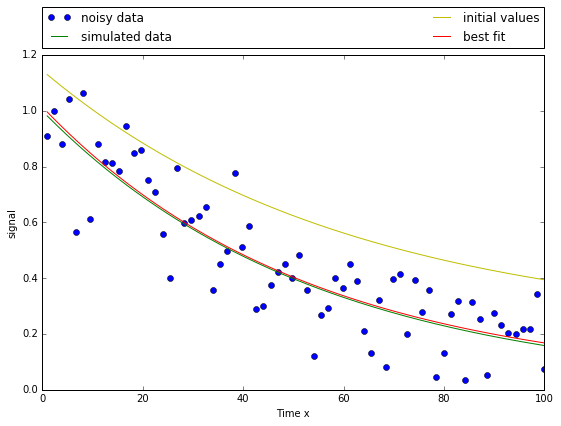

In [5]:
bareexponentialdecay_testing()

In [6]:
def stretchedexponentialdecay_testing():
    x_axis = np.linspace(0, 51, 100)
    x_nice = np.linspace(x_axis[0], x_axis[-1], 100)

    mod, params = fitlogic.make_decayexponentialstretched_model()
    print('Parameters of the model', mod.param_names,
          ' with the independet variable', mod.independent_vars)

    params['beta'].value = 2 + abs(np.random.normal(0,0.5))
    params['amplitude'].value = 10 #- abs(np.random.normal(0,20))
    params['lifetime'].value =1 + abs(np.random.normal(0,30))
    params['offset'].value = 1 + abs(np.random.normal(0, 20))
    print('\n', 'amplitude', params['amplitude'].value, '\n', 'lifetime',
          params['lifetime'].value,'\n', 'offset', params['offset'].value,'\n',
          'beta', params['beta'].value)

    data_noisy = (mod.eval(x=x_axis, params=params) + 1.5* np.random.normal(size=x_axis.shape))

    result = fitlogic.make_decayexponentialstretched_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_decayexponentialstretched)

    data = data_noisy
    #calculation of offset
    offset = data[-max(1,int(len(x_axis)/10)):].mean()
    if data[0]<data[-1]:
        params['amplitude'].max = 0-data.std()
        data_sub = offset - data
    else:
        params['amplitude'].min = data.std()
        data_sub = data-offset

    amplitude = (data_sub.max()
                 - data_sub[-max(1, int(len(x_axis)/10)):].mean() 
                 - data_sub[-max(1,int(len(x_axis)/10)):].std())
    
    data_level = data_sub / amplitude

    a = 0
    b = len(data_sub)
    for i in range(0,len(data_sub)):
        if data_level[i]>=1:
            a=i+1
        if data_level[i] <=data_level.std():
            b=i
            break
    print(a,b)

    try:
        double_lg_data = np.log(-np.log(data_level[a:b]))

        #linear fit, see linearmethods.py
        X = np.log(x_axis[a:b])
        linear_result = fitlogic.make_linear_fit(axis=X, data=double_lg_data, add_parameters= None)
        print(linear_result.params)
        
        plt.plot(np.log(x_axis),np.log(-np.log(data_level)),'ob')
        plt.plot(np.log(x_axis[a:b]),linear_result.best_fit,'-r')
        plt.plot(np.log(x_axis[a:b]),linear_result.init_fit,'-y')
        print(linear_result.fit_report())
        plt.show()
    except:
        print("except")
        
    plt.plot(x_axis, data_noisy, 'ob')
    plt.plot(x_nice, mod.eval(x=x_nice, params=params), '-g', label='original')
    print(result.fit_report())
    plt.plot(x_axis, result.best_fit, '-r', linewidth=2.0, label='best fit')
    plt.plot(x_axis, result.init_fit, '-y', linewidth=2.0, label='init fit')
    plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

Parameters of the model ['amplitude', 'beta', 'lifetime', 'offset']  with the independet variable x

 amplitude 10 
 lifetime 25.45435158433316 
 offset 22.411419691785575 
 beta 3.1633038351773384
23 47
except
[[Model]]
    ((Model(amplitude_function) * Model(barestretchedexponentialdecay_function)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 100
    # variables        = 4
    chi-square         = 267.986
    reduced chi-square = 2.792
[[Variables]]
    amplitude:   10.5023193 +/- 0.615271 (5.86%) (init= 9.996188)
    beta:        2.86870721 +/- 0.449837 (15.68%) (init= 2)
    lifetime:    25.0300186 +/- 1.076762 (4.30%) (init= 22.05829)
    offset:      22.4835005 +/- 0.382847 (1.70%) (init= 22.4585)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, offset)         = -0.745 
    C(amplitude, beta)           = -0.714 
    C(lifetime, offset)          = -0.632 
    C(beta, offset)              =  0.495 
    

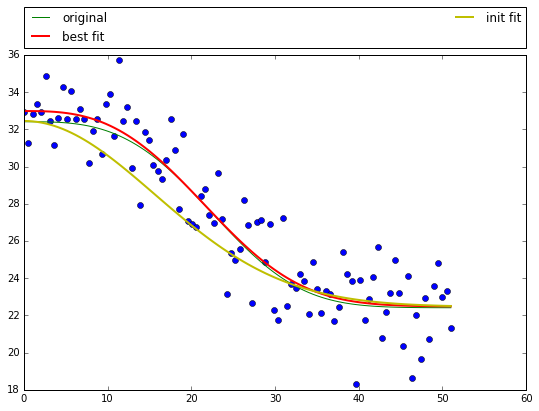

In [7]:
stretchedexponentialdecay_testing()